In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [89]:
import numpy as np
# from cmocean import cm
import netCDF4 as nc
import matplotlib.pyplot as plt

#rcparams
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

#### Notes to self:
#### OVERARCHING GOAL of project: 
Understand role of changing atmospheric ozone in carbon sink of the southern ocean
#### Experimental design:
"Therefore, we will have three set of forcing, one with no ozone, one with ozone but no ozone recovery, and one with best estimated ozone recovery. This set will nicely border the possible evolution of ozone this century." (from CELOS grant)
#### Goal of this notebook:
Familiarize self with the various forcing products. 
#### Knowledge gaps to fill in:
    - where are the 3 sets of forcing? how do they work?
#### location notes from dave:
    This is the standard forcing we use for our model runs
            `/gpfs/data/greenocean/software/products/NCEPForcingData/`
    ERA5 forcing (still being verified), in daily and 6-hourly
            `/gpfs/data/greenocean/software/products/ERA5Forcing/`
    This is what Kat Turner (master’s student) produced. The forcing data for the model based on the Met Office data
            `/gpfs/data/greenocean/software/products/MetOffice/withOzone/`
    This is the data we received from The Met Office (note we have 2 directories called < insert something unfathomable > )
            `/gpfs/data/greenocean/software/resources/MetOffice/ozone/`

#### 

### open year 2020 of metoffice data and NCEP standard forcing data

In [90]:
tdir = '/gpfs/data/greenocean/software/products/MetOffice/withOzone/'
tfilmet = 'MetOffice_wind2020.nc'
MO = nc.Dataset(f'{tdir}{tfilmet}')
print('')
print(f'{tfilmet} file contents')
print(MO)

tdirncep = '/gpfs/data/greenocean/software/products/NCEPForcingData/'
tfilncep = 'ncep_bulk_2020.nc'
print('')
print(f'{tfilncep} file contents')
NCEP = nc.Dataset(f'{tdirncep}{tfilncep}')
print(NCEP)


MetOffice_wind2020.nc file contents
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), time_counter(365)
    variables(dimensions): float32 glam(y,x), float32 gphi(y,x), float32 time_counter(time_counter), float64 uwind10m(time_counter,y,x), float64 vwind10m(time_counter,y,x)
    groups: 


ncep_bulk_2020.nc file contents
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): x(182), y(149), deptht(1), time_counter(366)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(y,x), float32 time_counter(time_counter), float32 air(time_counter,y,x), float32 pres(time_counter,y,x), float32 humidity(time_counter,y,x), float32 wspd(time_counter,y,x), float32 uwnd(time_counter,y,x), float32 vwnd(time_counter,y,x), float32 tcdc(time_counter,y,x), float32 prate(time_counter,y,x)
    groups: 



#### let's get out wind speed (sqrt(u2+v2)), plot one day for each, and plot domain averages over the course of the year

In [91]:
MO_uw = MO['uwind10m'][:]
MO_vw = MO['vwind10m'][:]
MO_wspd = np.sqrt(MO_uw**2 + MO_vw**2)
print(f'Met Office ozone forcing, year 2020 max. windspeed: {np.nanmax(MO_wspd)}')
print(f'Met Office ozone forcing, year 2020 min. windspeed: {np.nanmin(MO_wspd)}')
NCEP_uw = NCEP['uwnd'][:]
NCEP_vw = NCEP['vwnd'][:]
NCEP_origwspd = NCEP['wspd'][:]
NCEP_wspd = np.sqrt(NCEP_uw**2 + NCEP_vw**2)
print(f'NCEP standard forcing, year 2020 max. (calculated) windspeed: {np.nanmax(NCEP_wspd)}')
print(f'NCEP standard forcing, year 2020 min. (calculated) windspeed: {np.nanmin(NCEP_wspd)}')
print('comparing calculated windspeed from the u and v velocities (just now) with what is included a priori in the netcdf:')
print(f'NCEP standard forcing, year 2020 max. (orig included) windspeed: {np.nanmax(NCEP_origwspd)}')
print(f'NCEP standard forcing, year 2020 min. (orig included) windspeed: {np.nanmin(NCEP_origwspd)}')
print('close but not identical...rounding? what?')

Met Office ozone forcing, year 2020 max. windspeed: 28.792690882133865
Met Office ozone forcing, year 2020 min. windspeed: 0.0013395665318499729
NCEP standard forcing, year 2020 max. (calculated) windspeed: 31.512340545654297
NCEP standard forcing, year 2020 min. (calculated) windspeed: 0.0009264976833947003
comparing calculated windspeed from the u and v velocities (just now) with what is included a priori in the netcdf:
NCEP standard forcing, year 2020 max. (orig included) windspeed: 31.82965660095215
NCEP standard forcing, year 2020 min. (orig included) windspeed: 0.0
close but not identical...rounding? what?


In [92]:
print(np.shape(MO_wspd))

(365, 149, 182)


### What does a day of wind speed look like for these two products?

##### colormaps for now (need to install cmocean to work with python?):
cividis for sequential, coolwarm for diverging
https://www.analyticsvidhya.com/blog/2020/09/colormaps-matplotlib/#:~:text=Sequential%20Colormaps%20that%20is%20provided,and%20Misc%20colormaps%20in%20Matplotlib.

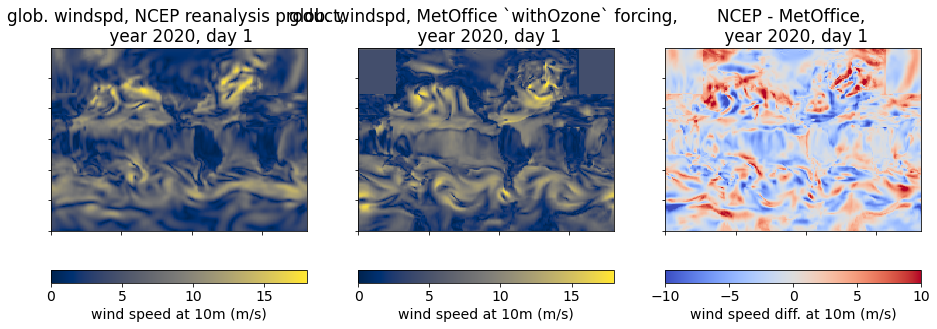

In [93]:
fact = 0.6
fig, axs = plt.subplots(1,3, figsize=(26*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tvmax = 18
#ncep
ncep = axs[0].pcolormesh(NCEP_wspd[0,:,:], cmap='cividis', vmin = 0, vmax = tvmax)
fig.colorbar(ncep, ax=axs[0], orientation = 'horizontal', label = 'wind speed at 10m (m/s)')
q =axs[0].set_title('glob. windspd, NCEP reanalysis product, \n year 2020, day 1')
q = axs[0].set_xticklabels([]); q =axs[0].set_yticklabels([])

mo = axs[1].pcolormesh(MO_wspd[0,:,:], cmap='cividis', vmin = 0, vmax = tvmax)
fig.colorbar(mo, ax=axs[1], orientation = 'horizontal', label = 'wind speed at 10m (m/s)')
q =axs[1].set_title('glob. windspd, MetOffice `withOzone` forcing, \n year 2020, day 1')
q =axs[1].set_xticklabels([]); q =axs[1].set_yticklabels([])


diff = axs[2].pcolormesh(NCEP_wspd[0,:,:]-MO_wspd[0,:,:], cmap='coolwarm', vmin = -10, vmax = 10)
fig.colorbar(diff, ax=axs[2], orientation = 'horizontal', label = 'wind speed diff. at 10m (m/s)')
q =axs[2].set_title('NCEP - MetOffice, \n year 2020, day 1')
q = axs[2].set_xticklabels([]); q =axs[2].set_yticklabels([])


#### rough view: domainwide mean windspeed for the two products over the course of the year. 

##### why does the ncep reanalysis have 366 days but MO only 365? well whatever

In [94]:
print(np.shape(NCEP_wspd))
NCEP_wspd_mean = np.nanmean(np.nanmean(NCEP_wspd, axis = 1),axis = 1)
print(np.shape(MO_wspd))
MO_wspd_mean = np.nanmean(np.nanmean(MO_wspd, axis = 1),axis = 1)

(366, 149, 182)
(365, 149, 182)


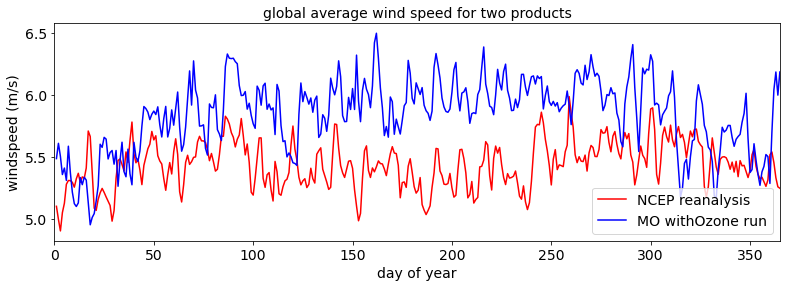

In [95]:
fact = 0.5; fs = 14
fig, axs = plt.subplots(1,1, figsize=(26*fact, 8*fact), facecolor='w', edgecolor='k')
daze = np.arange(1,366,1)
axs.plot(daze,NCEP_wspd_mean[0:365], color = 'red', label = 'NCEP reanalysis')
axs.plot(daze,MO_wspd_mean[0:365], color = 'blue', label = 'MO withOzone run')
axs.set_xlim([0,365])
axs.set_xlabel('day of year', fontsize = fs)
axs.set_ylabel('windspeed (m/s)', fontsize = fs)
axs.set_title('global average wind speed for two products', fontsize = fs)
axs.legend(fontsize = fs)